In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from scipy.stats import chi2_contingency

In [3]:
df = pd.read_csv("amz_uk_price_prediction_dataset.csv")
df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


## Part 1: Analyzing Best-Seller Trends Across Product Categories

In [4]:
# Crosstab
ct = pd.crosstab(df['category'], df['isBestSeller'])
ct

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [ ]:
# Proportions by descending order

ct_prop = ct.div(ct.sum(axis=1), axis=0)
ct_prop = ct_prop.sort_values(by=True, ascending=False)
ct_prop.head(10)

isBestSeller,False,True
category,,
Grocery,0.941865,0.058135
Smart Home Security & Lighting,0.942308,0.057692
Health & Personal Care,0.942314,0.057686
Mobile Phone Accessories,0.957529,0.042471
Power & Hand Tools,0.964661,0.035339
"Billiard, Snooker & Pool",0.967871,0.032129
Pet Supplies,0.969800,0.030200
Home Brewing & Wine Making,0.971545,0.028455
Mirrors,0.972000,0.028000


In [10]:
ct_prop[True].sort_values(ascending=False).head(10)

category
Grocery                           0.058135
Smart Home Security & Lighting    0.057692
Health & Personal Care            0.057686
Mobile Phone Accessories          0.042471
Power & Hand Tools                0.035339
Billiard, Snooker & Pool          0.032129
Pet Supplies                      0.030200
Home Brewing & Wine Making        0.028455
Mirrors                           0.028000
Wind Instruments                  0.028000
Name: True, dtype: float64

Top best sellers in each category shows that best sellers are rare, top 1 having only ~5.8%, having 2 more categories with above 5.5% best seller items and the rest with a percentage less than 4.5%.

This confirms that best sellers are rare and not concentrated in one or two categories but distributed among categories.

In [6]:
# Chi-square test

chi2, p, dof, expected = chi2_contingency(ct)

print("Chi2:", chi2)
print("p-value:", p)

Chi2: 36540.20270061387
p-value: 0.0


In [9]:
cramers_v

np.float64(0.1222829439760564)

In [7]:
n = ct.values.sum()
cramers_v = np.sqrt(chi2 / (n * (min(ct.shape)-1)))
cramers_v

np.float64(0.1222829439760564)

The Chi-square test of independence returned a p-value effectively equal to zero, indicating a statistically significant relationship between product category and best-seller status.

However, Cramers V was calculated at 0.122, suggesting that the strength of this association is weak.

This indicates that while product category has some influence on whether a product becomes a best-seller, it is not a strong determining factor. Other variables, such as pricing, reviews, or brand factors, are likely to play a more substantial role in driving best-seller performance.

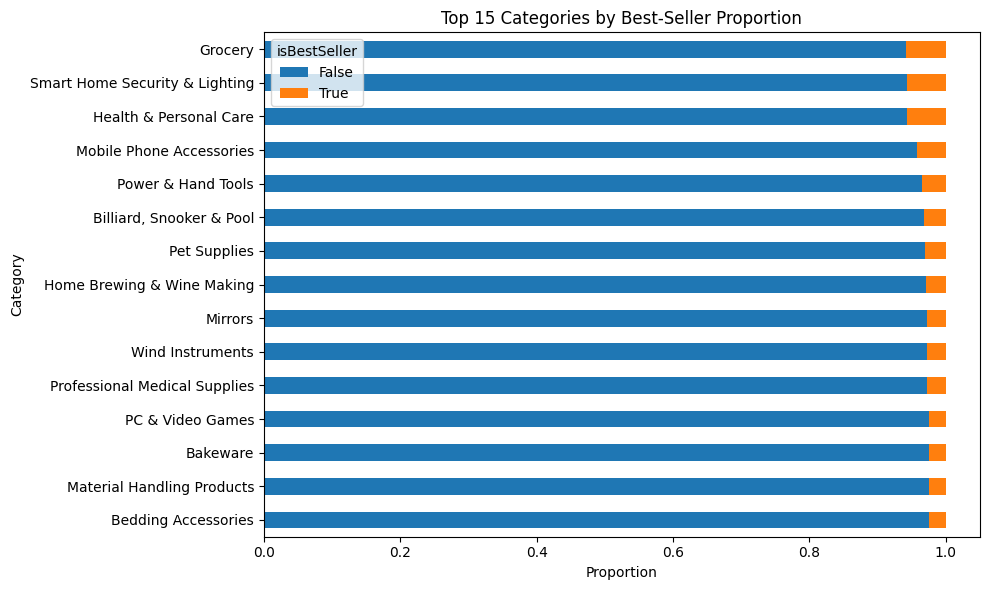

In [12]:
# Barplot with top categories

top15 = ct_prop.sort_values(by=True, ascending=False).head(15)

top15.plot(kind='barh', stacked=True, figsize=(10,6))
plt.title("Top 15 Categories by Best-Seller Proportion")
plt.xlabel("Proportion")
plt.ylabel("Category")
plt.gca().invert_yaxis()  # puts highest at the top
plt.tight_layout()
plt.show()

Due to large numbers of product categories, visualization was limited to a top15 and barplot was done horizontally to improve readability.

Again, this plot confirms relationship between categories and best sellers is weak.

## Part 2: Exploring Product Prices and Ratings Across Categories and Brands

In [13]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

df_clean.shape

(2115963, 9)

Outliers were removed using the IQR method to ensure that extreme price values do not distort the analysis and lead to misleading conclusions.

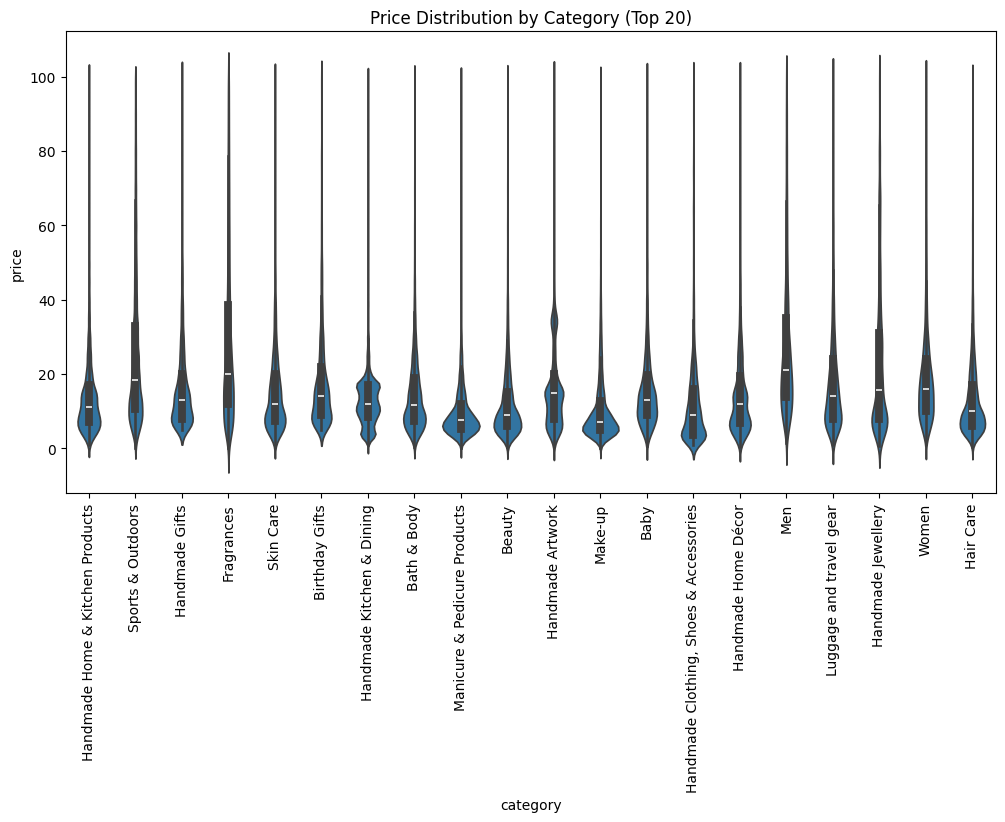

In [ ]:
# Price distribution among top 20 categories with violin plot
top20 = df_clean['category'].value_counts().nlargest(20).index
df_top20 = df_clean[df_clean['category'].isin(top20)]

plt.figure(figsize=(12,6))
sns.violinplot(data=df_top20, x='category', y='price')
plt.xticks(rotation=90)
plt.title("Price Distribution by Category (Top 20)")
plt.show()

In [15]:
df_clean.groupby('category')['price'].median().sort_values(ascending=False).head(10)

category
Desktop PCs               74.00
Boxing Shoes              69.79
Tablets                   69.00
Graphics Cards            68.54
Motherboards              67.92
Made in Italy Handmade    64.00
Digital Frames            63.90
Streaming Clients         62.68
Golf Shoes                62.39
Ski Helmets               61.33
Name: price, dtype: float64

Most categories have a balanced distribution on price, the average price on each category is between 60 to 74.

Not a single category with a higher concentration of products in the higher cost section.

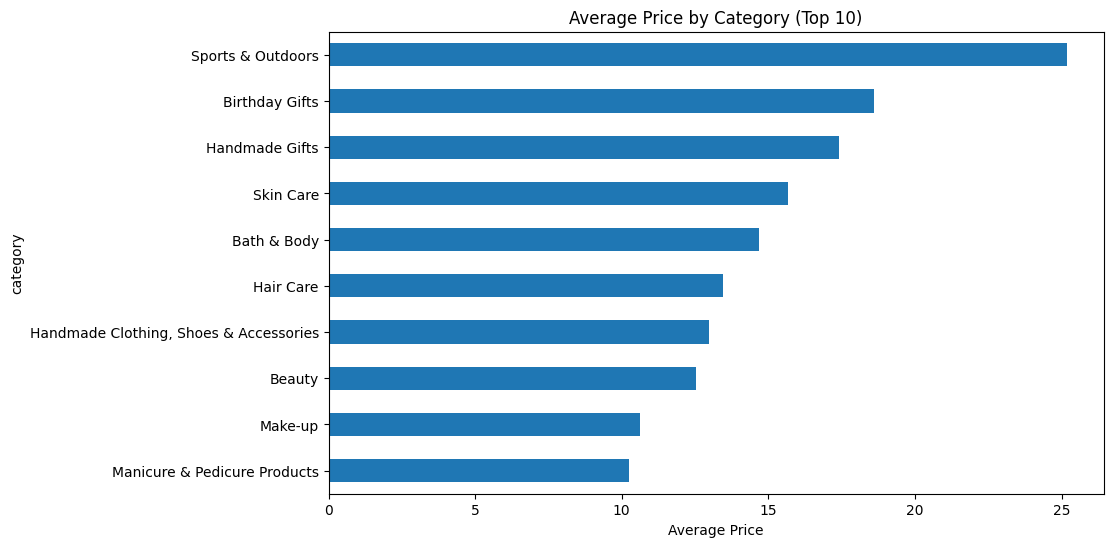

In [16]:
# Bar chart for the average price

top10 = df_clean['category'].value_counts().nlargest(10).index
df_top10 = df_clean[df_clean['category'].isin(top10)]

avg_price = df_top10.groupby('category')['price'].mean().sort_values()

avg_price.plot(kind='barh', figsize=(10,6))
plt.title("Average Price by Category (Top 10)")
plt.xlabel("Average Price")
plt.show()

In [18]:
df_clean.groupby('category')['price'].mean().sort_values(ascending=False).head(20)

category
Motherboards                              68.772432
Boxing Shoes                              67.417803
Desktop PCs                               66.915562
Tablets                                   66.552971
Graphics Cards                            65.103509
Digital Frames                            60.745129
Streaming Clients                         60.241803
Hockey Shoes                              60.094796
Computer Cases                            58.339884
Skiing Poles                              57.867770
Ski Helmets                               57.574348
Made in Italy Handmade                    56.398398
Home Office Furniture                     56.244444
3D Printers                               55.739722
Motorbike Batteries                       55.658330
Golf Shoes                                55.361627
Alexa Built-In Devices                    53.927692
Dining Room Furniture                     53.552040
Motorbike Handlebars, Controls & Grips    53.479949
Men

Categories with higher average prices likely represent premium or specialized products, while lower-priced categories indicate commoditized or highly competitive segments.

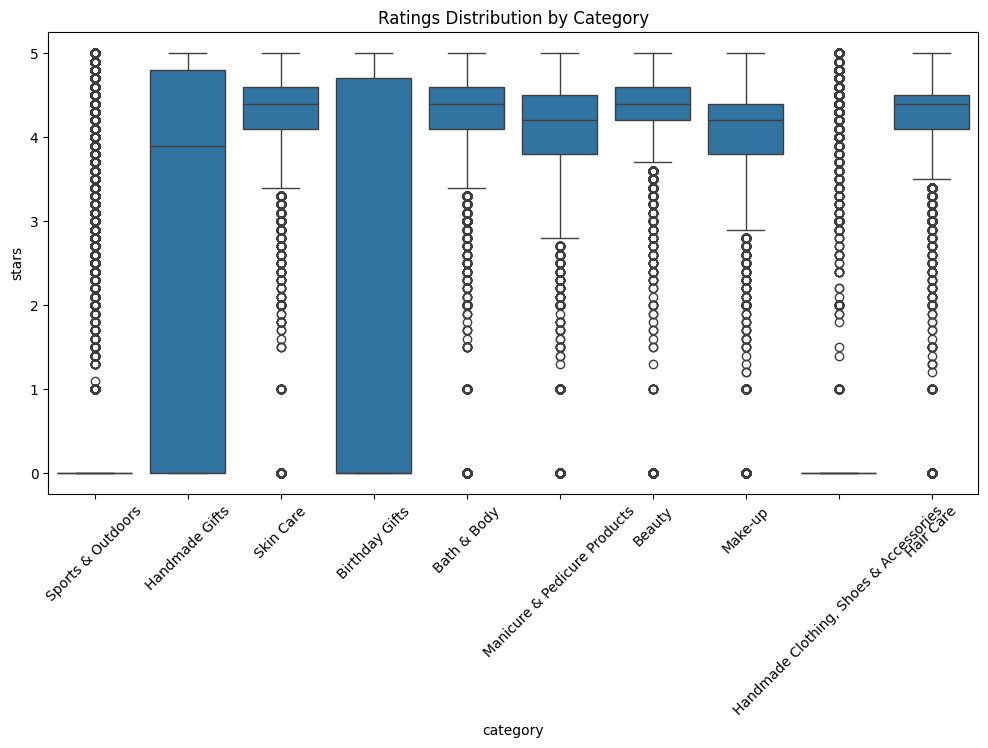

In [20]:
# Boxplot for ratings by category

top10 = df_clean['category'].value_counts().nlargest(10).index
df_top10 = df_clean[df_clean['category'].isin(top10)]

plt.figure(figsize=(12,6))
sns.boxplot(data=df_top10, x='category', y='stars')
plt.xticks(rotation=45)
plt.title("Ratings Distribution by Category")
plt.show()

In [21]:
df_clean.groupby('category')['stars'].median().sort_values(ascending=False).head(10)

category
Computer Memory                 4.7
Beer, Wine & Spirits            4.6
Building & Construction Toys    4.6
Office Paper Products           4.6
Kids' Play Figures              4.6
Laptop Accessories              4.6
Hobbies                         4.6
Luxury Food & Drink             4.6
Soft Toys                       4.5
Boxes & Organisers              4.5
Name: stars, dtype: float64

Mostly all categories have positive ratings, having a few categories with some outliers but not significant to change the outcome.

Computer Memory commands the highest median rating. 

## PART 3 - CoInvestigating the Interplay Between Product Prices and Ratings

In [22]:
# Correlation

corr = df_clean[['price', 'stars']].corr()
corr

,price,stars
price,1.000000,-0.077673
stars,-0.077673,1.000000


In [23]:
corr_value = corr.loc['price', 'stars']
print(corr_value)

-0.07767299878181261


Correlation between price and rating is extremely weak, indicating that higher-priced products do not necessarily receive better customer ratings.

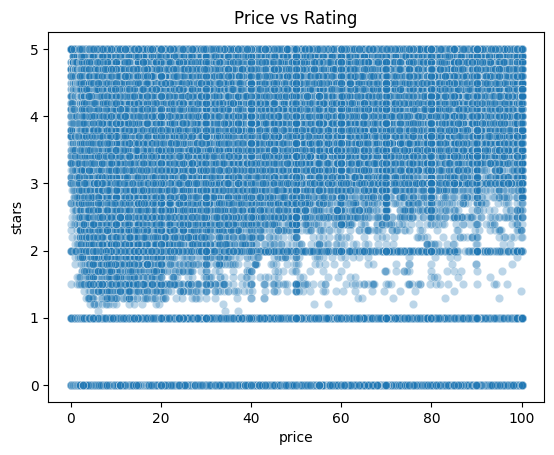

In [24]:
# Scatter Plot

sns.scatterplot(data=df_clean, x='price', y='stars', alpha=0.3)
plt.title("Price vs Rating")
plt.show()

The scatter plot shows no clear trend, reinforcing that product price is not a strong predictor of customer satisfaction.

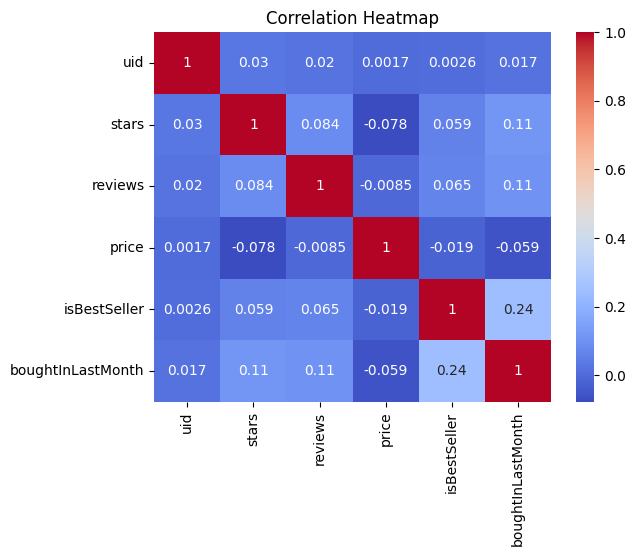

In [25]:
# Heatmap

sns.heatmap(df_clean.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

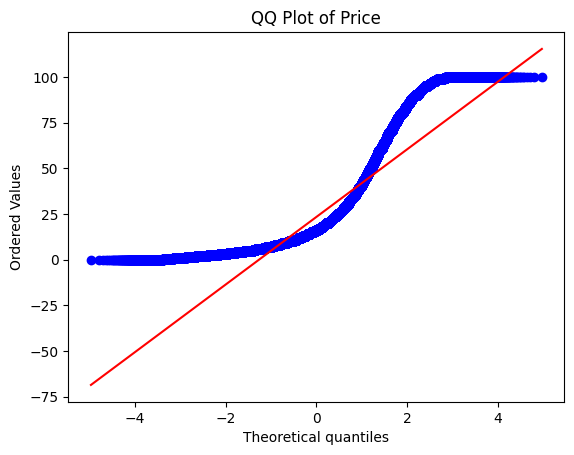

In [28]:
stats.probplot(df_clean['price'], dist="norm", plot=plt)
plt.title("QQ Plot of Price")
plt.show()

Despite these differences, product ratings show little dependence on price, suggesting that higher cost does not necessarily translate into better customer satisfaction.

Additionally, price distributions are skewed, indicating that most products fall within lower price ranges, with relatively few high-priced items.

Overall, these findings suggest that businesses should focus not only on pricing strategies but also on product quality, customer experience, and review generation to improve performance.